In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tvDatafeed import TvDatafeed, Interval

In [2]:
import requests
import json
import datetime

In [3]:
n=1

In [4]:
tv = TvDatafeed()
def getdata(name):
    data=tv.get_hist(symbol=name,exchange='BINANCE',interval=Interval.in_daily,n_bars=5000)
    data=data.reset_index()
#     data["datetime"]=data["datetime"]+datetime.timedelta(days=1)
    data["datetime"]=data["datetime"].dt.strftime('%Y-%m-%d')
    data2=data[data["datetime"]>="2020-01-01"].copy()
    data2["datetime"] = pd.to_datetime(data2["datetime"])
    return data2

you are using nologin method, data you access may be limited


In [5]:
def getapi(api):
    response_API=requests.get(api)
    data=response_API.text
    parse_json=json.loads(data)
    df = pd.json_normalize(parse_json['values'])
    listtime=list(df['x'])
    listtime2=[]
    for i in listtime:
        listtime2.append(datetime.datetime.fromtimestamp(i).strftime('%Y-%m-%d'))
    df['datetime']=pd.Series(listtime2)
    df["datetime"] = pd.to_datetime(df["datetime"])
#     df["datetime"]=df["datetime"]+datetime.timedelta(days=1)
    df=df[df["datetime"]>="2020-01-01"].copy()
    df=df.drop(columns=['x'])
    df.rename(columns={'y':'value'},inplace=True)
    df=df.drop_duplicates(subset=['datetime'])
    return df

In [6]:
bitcoi=getdata('BTCUSDT')
eth=getdata('ETHUSDT')
bnb=getdata('BNBUSDT')
ada=getdata('ADAUSDT')
bitcoi=bitcoi[["datetime","volume","open","high","low","close"]]
bitcoi.tail(5)

,datetime,volume,open,high,low,close
1640,2022-02-11,26556.85681,42373.73,43079.49,41688.88,42217.87
1641,2022-02-12,17648.58975,42217.87,42760.00,41870.00,42053.66
1642,2022-02-13,34010.13060,42053.65,42842.40,41550.56,42535.94
1643,2022-02-14,38093.46331,42535.94,44751.40,42427.03,44544.86
1644,2022-02-15,2563.88531,44544.85,44549.97,43945.32,44028.24


In [7]:
number_transactions=getapi('https://api.blockchain.info/charts/n-transactions?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
number_address=getapi('https://api.blockchain.info/charts/n-unique-addresses?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
transaction_second=getapi('https://api.blockchain.info/charts/transactions-per-second?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
transaction_second=transaction_second.groupby(['datetime']).mean().reset_index()
total_bitcoin=getapi('https://api.blockchain.info/charts/total-bitcoins?timespan=4years&rollingAverage=24hours&format=json&sampled=true')
volume_trade=getapi('https://api.blockchain.info/charts/trade-volume?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
hash_rate=getapi('https://api.blockchain.info/charts/hash-rate?timespan=4years&rollingAverage=24hours&format=json&sampled=false')

In [8]:
bitcoin=bitcoi.merge(eth[["datetime","close"]],on='datetime',how='left',suffixes=('_bitcoin', '_eth'))
bitcoin=bitcoin.merge(bnb[["datetime","close"]],on='datetime',how='left')
bitcoin=bitcoin.merge(ada[["datetime","close"]],on='datetime',how='left',suffixes=('_bnb', '_ada'))

In [9]:
data_api=number_transactions.merge(number_address,on='datetime',how='left',suffixes=('_number_transaction', '_number_address'))
data_api=data_api.merge(transaction_second,on='datetime',how='left')
data_api=data_api.merge(total_bitcoin,on='datetime',how='left',suffixes=('_transaction_second', '_total_bitcoin'))
data_api=data_api.merge(volume_trade,on='datetime',how='left')
data_api=data_api.merge(hash_rate,on='datetime',how='left',suffixes=('_volume_trade', '_hash_rate'))


In [10]:
bitcoin=bitcoin.merge(data_api,on='datetime',how='left')
bitcoin.tail(5)

,datetime,volume,open,high,low,close_bitcoin,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin,value_volume_trade,value_hash_rate
772,2022-02-11,26556.85681,42373.73,43079.49,41688.88,42217.87,2918.88,403.6,1.059,228189.0,604018.0,3.068403,1.895464e+07,3.225592e+08,2.481103e+08
773,2022-02-12,17648.58975,42217.87,42760.00,41870.00,42053.66,2871.13,397.9,1.042,208977.0,590527.0,2.986458,1.895553e+07,1.404551e+08,2.096333e+08
774,2022-02-13,34010.13060,42053.65,42842.40,41550.56,42535.94,2929.75,403.4,1.049,247592.0,630477.0,2.536632,1.895642e+07,9.067330e+07,2.029994e+08
775,2022-02-14,38093.46331,42535.94,44751.40,42427.03,44544.86,3183.52,432.4,1.107,273623.0,680501.0,2.481250,1.895731e+07,1.878267e+08,2.321888e+08
776,2022-02-15,2563.88531,44544.85,44549.97,43945.32,44028.24,3143.45,432.3,1.098,NaN,NaN,NaN,NaN,NaN,NaN


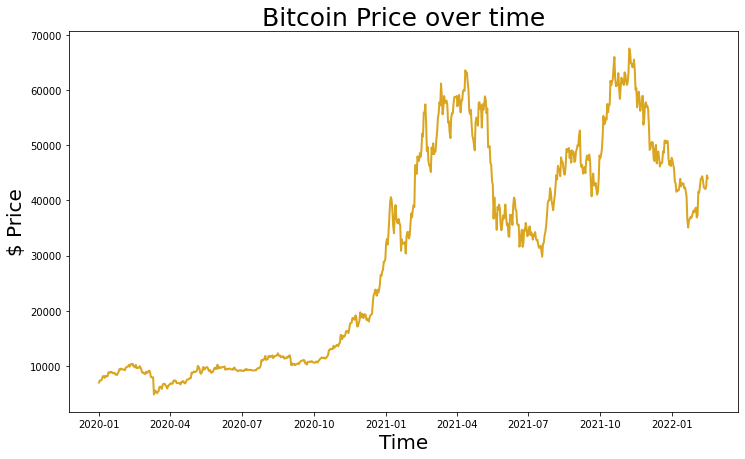

In [11]:
plt.figure(figsize = (12, 7))
plt.plot(bitcoin["datetime"], bitcoin["close_bitcoin"], color='goldenrod', lw=2)
plt.title("Bitcoin Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20)
plt.show()

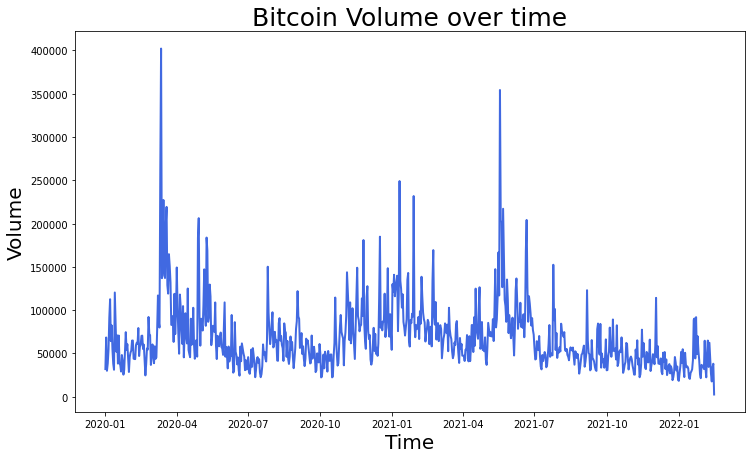

In [12]:
plt.figure(figsize = (12, 7))
plt.plot(bitcoin["datetime"], bitcoin["volume"], color='royalblue', lw=2)
plt.title("Bitcoin Volume over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("Volume", size=20);

In [13]:
bitcoin.isnull().sum()

datetime                     0
volume                       0
open                         0
high                         0
low                          0
close_bitcoin                0
close_eth                    0
close_bnb                    0
close_ada                    0
value_number_transaction     1
value_number_address         3
value_transaction_second     1
value_total_bitcoin         32
value_volume_trade           1
value_hash_rate              1
dtype: int64

In [14]:
# bitcoin=bitcoin.interpolate(method='linear')
temp=bitcoin["datetime"]
bitcoin=bitcoin.drop(columns=['datetime'])
bitcoin=bitcoin.interpolate()
bitcoin['datetime']=temp
bitcoin.isnull().sum()

volume                      0
open                        0
high                        0
low                         0
close_bitcoin               0
close_eth                   0
close_bnb                   0
close_ada                   0
value_number_transaction    0
value_number_address        0
value_transaction_second    0
value_total_bitcoin         0
value_volume_trade          0
value_hash_rate             0
datetime                    0
dtype: int64

In [15]:
required_features = ['volume','open', 'high', 'low','close_eth','close_bnb','close_ada','value_number_transaction','value_number_address','value_transaction_second','value_total_bitcoin','value_volume_trade', 'value_hash_rate']
output_label = 'close_bitcoin'

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

In [21]:
prediction_days = 30
df=bitcoin
df_train= df[:len(df)-prediction_days]
df_test= df[len(df)-prediction_days:]

In [22]:
df

,volume,open,high,low,close_bitcoin,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin,value_volume_trade,value_hash_rate,datetime
0,31951.483932,7200.77,7212.50,6924.74,6965.71,127.19,13.0105,0.03269,295567.0,475461.0,3.156424,1.813511e+07,2.860097e+07,9.671772e+07,2020-01-01
1,68428.500451,6965.49,7405.00,6871.04,7344.96,134.35,13.6474,0.03417,316517.0,523231.0,2.839931,1.813689e+07,6.828297e+07,1.159241e+08,2020-01-02
2,29987.974977,7345.00,7404.00,7272.21,7354.11,134.20,13.8092,0.03434,287215.0,465366.0,3.339583,1.813869e+07,1.368703e+08,1.152381e+08,2020-01-03
3,38331.085604,7354.19,7495.00,7318.00,7358.75,135.37,14.0532,0.03460,287779.0,459065.0,3.481424,1.814046e+07,5.018183e+07,1.118084e+08,2020-01-04
4,54635.695316,7357.64,7795.34,7346.76,7758.00,144.15,14.9471,0.03732,299146.0,522665.0,3.192535,1.814225e+07,4.817756e+07,9.260207e+07,2020-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,26556.856810,42373.73,43079.49,41688.88,42217.87,2918.88,403.6000,1.05900,228189.0,604018.0,3.068403,1.895464e+07,3.225592e+08,2.481103e+08,2022-02-11
773,17648.589750,42217.87,42760.00,41870.00,42053.66,2871.13,397.9000,1.04200,208977.0,590527.0,2.986458,1.895553e+07,1.404551e+08,2.096333e+08,2022-02-12
774,34010.130600,42053.65,42842.40,41550.56,42535.94,2929.75,403.4000,1.04900,247592.0,630477.0,2.536632,1.895642e+07,9.067330e+07,2.029994e+08,2022-02-13
775,38093.463310,42535.94,44751.40,42427.03,44544.86,3183.52,432.4000,1.10700,273623.0,680501.0,2.481250,1.895731e+07,1.878267e+08,2.321888e+08,2022-02-14


In [38]:
training_set = df_train[required_features]

In [31]:
training_set = min_max_scaler.fit_transform(training_set)
training_set.shape

(747, 13)

In [34]:
x_train = training_set[0:len(training_set)-1]
print(x_train.shape)
y_train = training_set[1:len(training_set)]
print(y_train.shape)
# x_train = np.reshape(x_train, (len(x_train), 1, 1))

(746, 13)
(746, 13)
